In [1]:
!nvidia-smi

Tue Sep 13 10:33:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   32C    P0    37W / 250W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:82:00.0 Off |                    0 |
| N/A   

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.transforms.functional as tF
from torch.utils.data import DataLoader
from superminddpm import DDPM, DummyEpsModel
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = DDPM(eps_model=DummyEpsModel(1), betas=(1e-4, 0.02), n_T=1000)
model.load_state_dict(torch.load("./contents/ddpm_mnist.pth", map_location=device))
model.to(device)
model.eval();

Model created


In [4]:
dataset = torch.load("./datasets/980_samples.pth", map_location=device)
seed = torch.load("./datasets/980_seed.pth", map_location=device)

n = dataset.shape[0]
samples = dataset[:, 0][:, None, ...]
original_noise = dataset[:, 1][:, None, ...]
labels = torch.load("./datasets/980_labels.pth", map_location=device)

In [7]:
torch.manual_seed(seed)
_ = torch.randn(n, *(1, 28, 28)).to(device) # Continue RNG state
with torch.no_grad():
    new_samples = model.sample(n, size=(1, 28, 28), starting_noise=original_noise, device=device)

In [47]:
def plot_samples(samples, title=None):
    n = samples.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n * 3, 3))
    if title:
        fig.suptitle(title, fontsize=20)
    for i in range(n):
        curr_axs = axs if n == 1 else axs[i]
        curr_axs.imshow(samples[i, 0].cpu(), cmap="gray")
    plt.show()

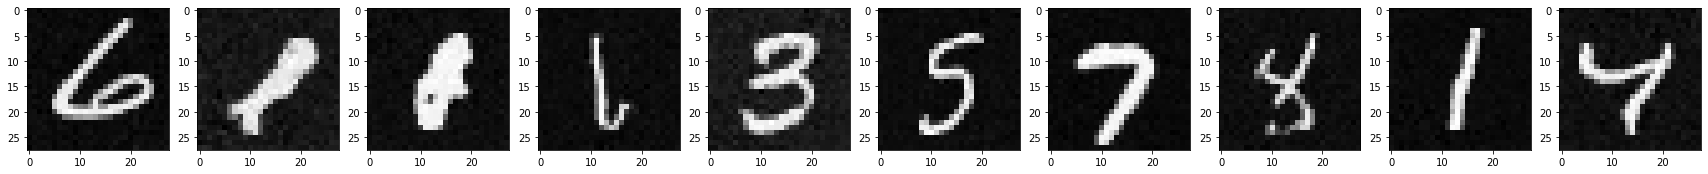

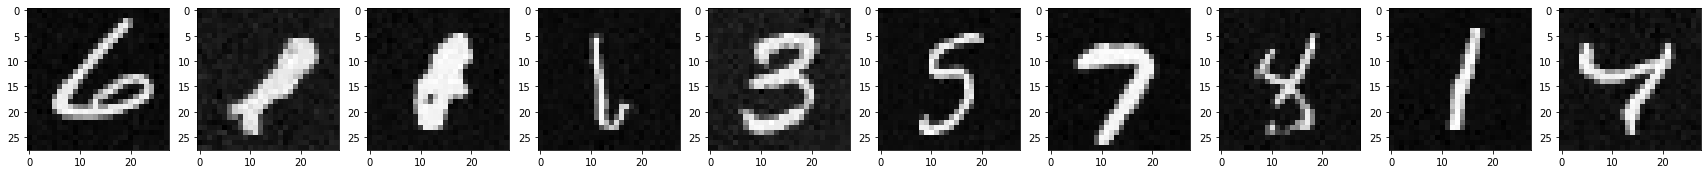

In [15]:
plot_samples(samples[0:10])
plot_samples(new_samples[0:10])
print()

### Showing removal of noise over steps

In [42]:
n = 8
x_t = torch.randn(n, *(1, 28, 28)).to(device)
torch.set_grad_enabled(False)
store_every= 10
stored = torch.Tensor(*(0, n, 1, 28, 28)).to(device)
stored_timestep = []
for t in range(1000, 0, -1):
    z = torch.randn(n, *(1, 28, 28)).to(device) if t > 1 else 0
    eps = model.eps_model(x_t, 0)
    x_t = (model.oneover_sqrta[t] * (x_t - eps * model.mab_over_sqrtmab[t]) + model.sqrt_beta_t[t] * z)
    if t%store_every == 0 or t==1:
        stored = torch.cat([stored, x_t[None, ...]], dim=0)
        stored_timestep.append(t)
        

    

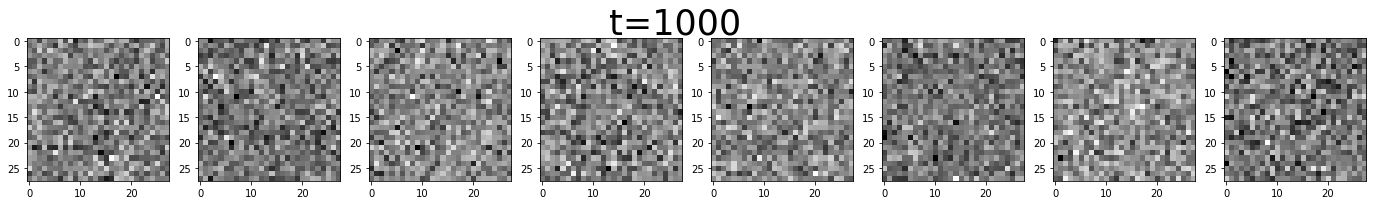

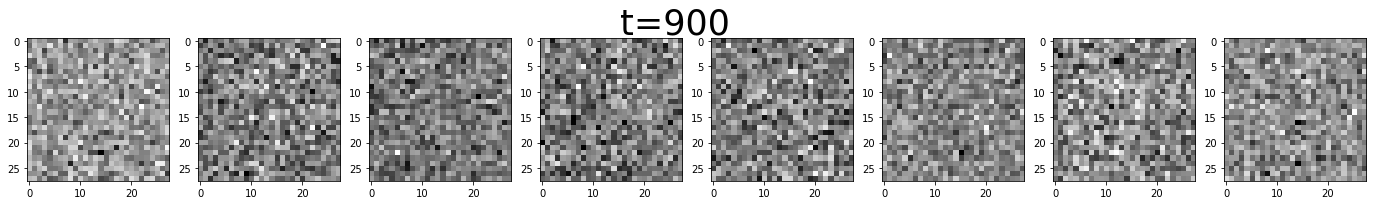

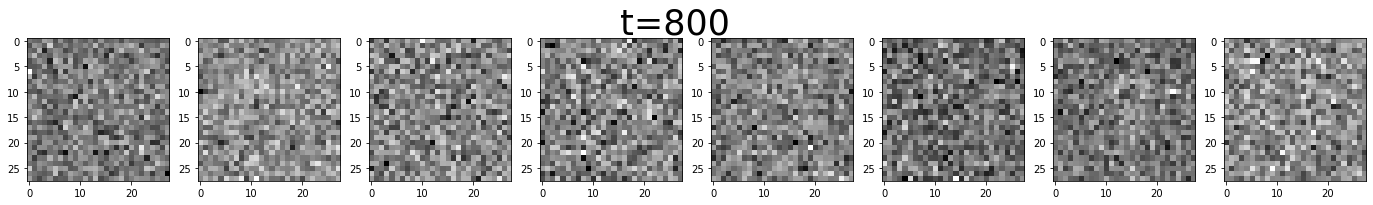

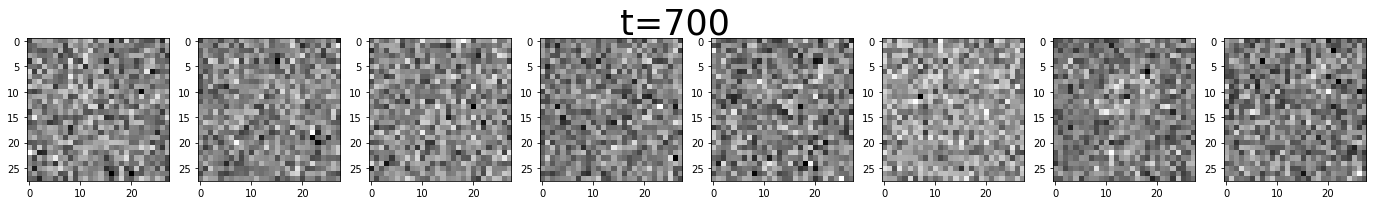

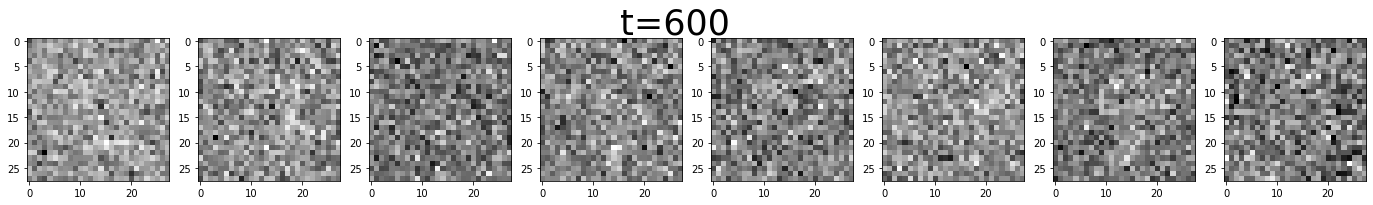

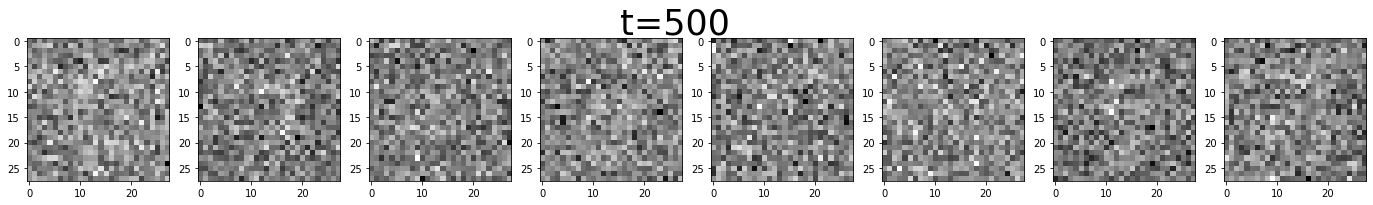

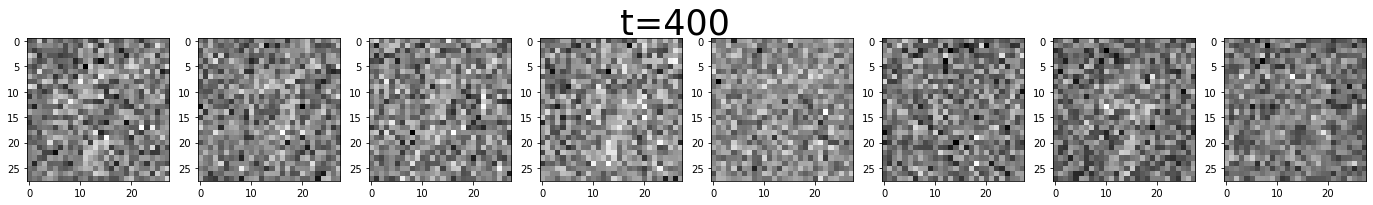

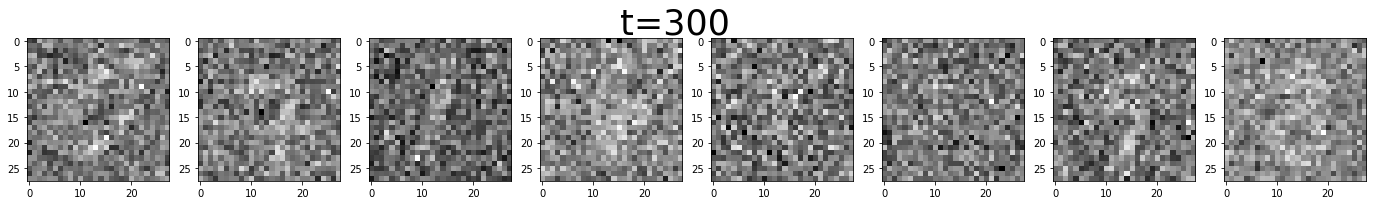

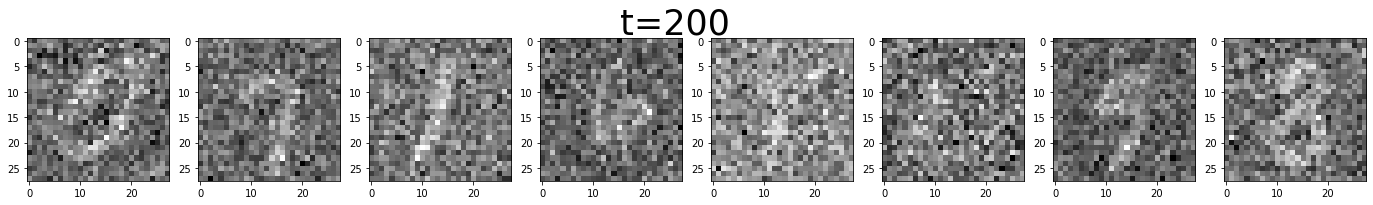

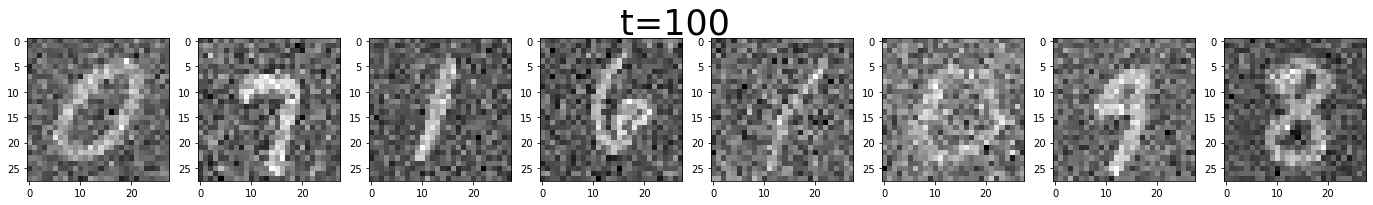

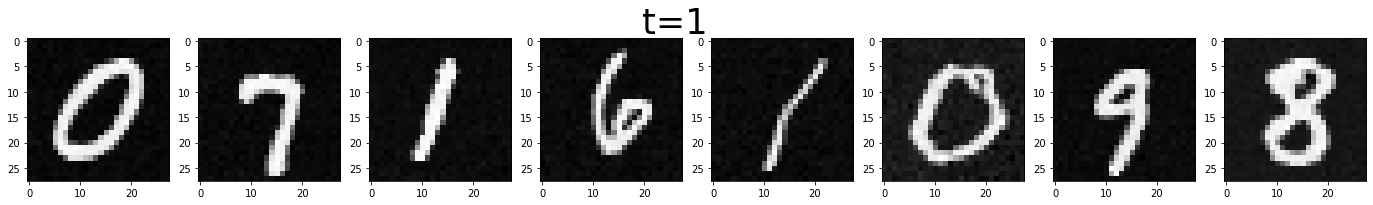

In [43]:
subset = stored[::10]
subset_t = stored_timestep[::10]
for subtensor, t in zip(subset, subset_t):
    plot_samples(subtensor, f"t={t}")

### Attempt at plotting "predicted x_0" from the Denoising Diffusion Implicit Models

In [86]:
n = 5
x_t = torch.randn(n, *(1, 28, 28)).to(device)
torch.set_grad_enabled(False)
predicted_x0s = torch.zeros(0, n, 1, 28, 28).to(device)
timestep_store = []
store_every = 50
for t in range(1000, 0, -1):
    eps = model.eps_model(x_t, 0)
    if t%store_every == 0:
        predicted_x0 = model.oneover_sqrta[t] * (x_t - (1-model.alpha_t[t])**0.5 * eps)
        predicted_x0s = torch.cat([predicted_x0s, predicted_x0[None, ...]], dim=0)
        timestep_store.append(t)
            
    z = torch.randn(n, *(1, 28, 28)).to(device) if t > 1 else 0
    
    x_t = (model.oneover_sqrta[t] * (x_t - eps * model.mab_over_sqrtmab[t]) + model.sqrt_beta_t[t] * z)


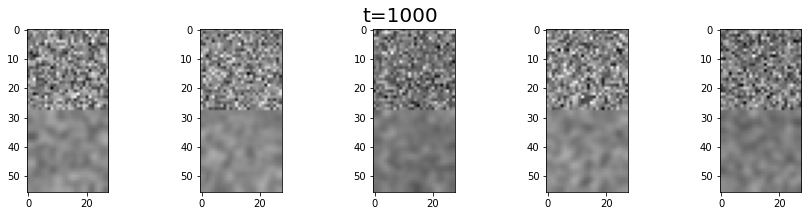

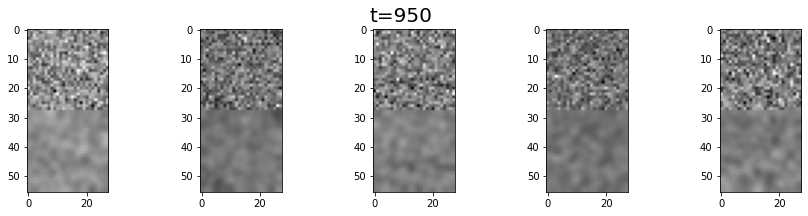

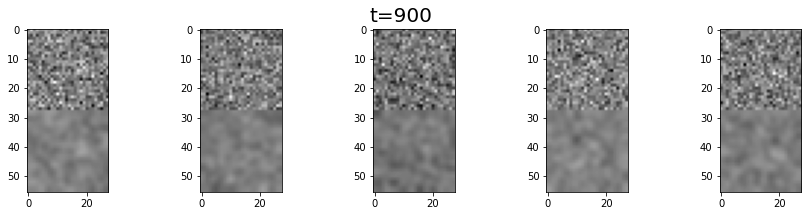

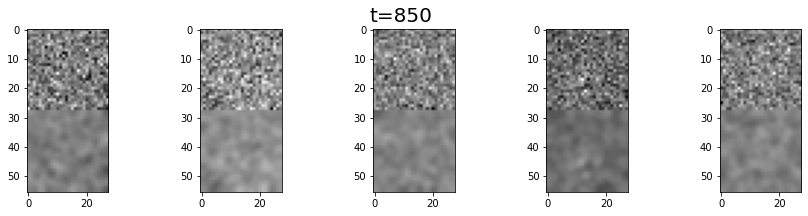

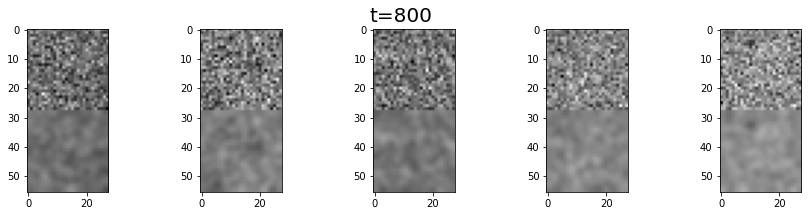

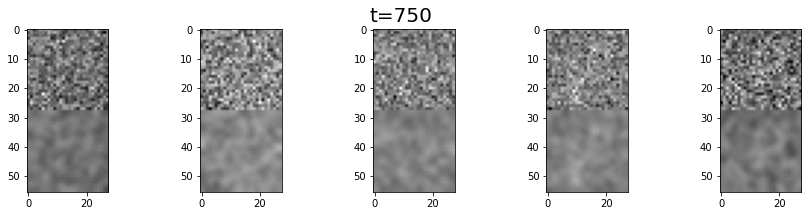

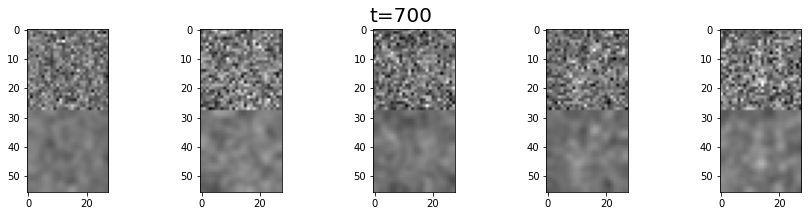

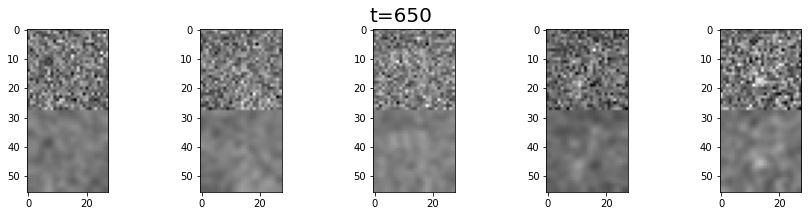

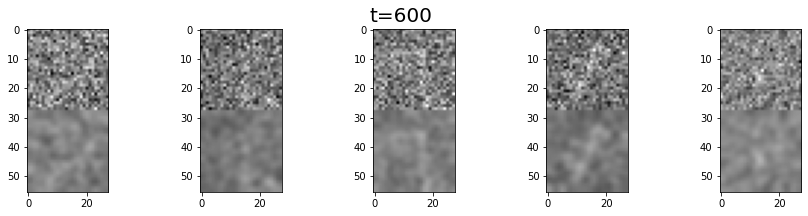

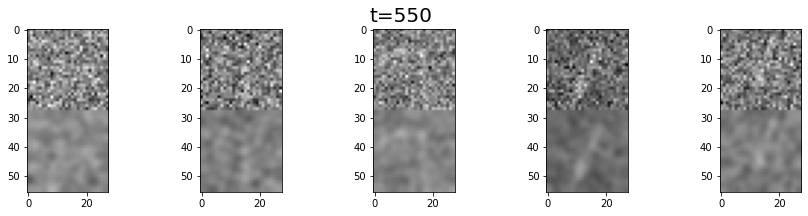

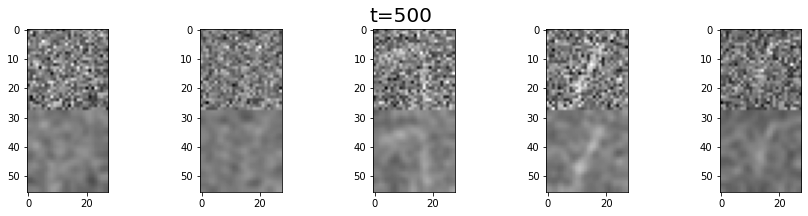

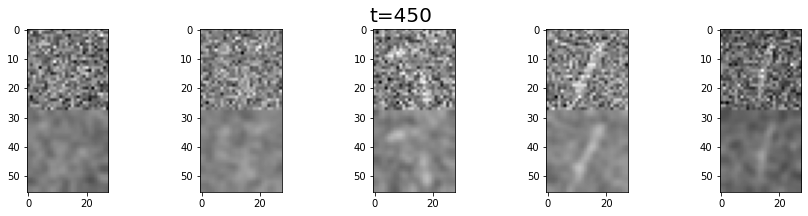

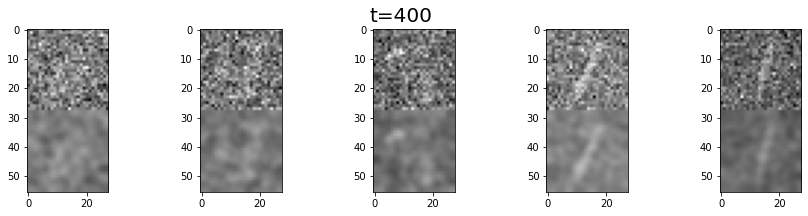

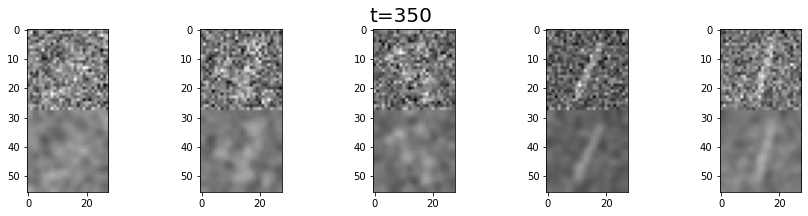

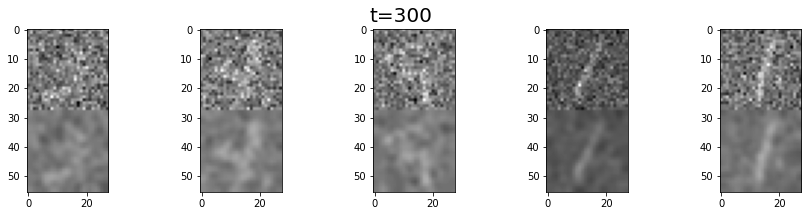

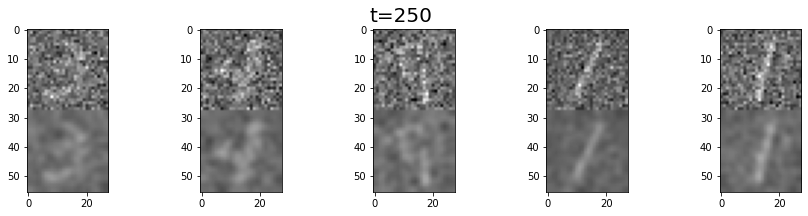

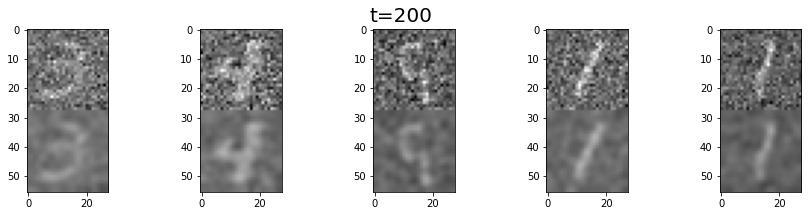

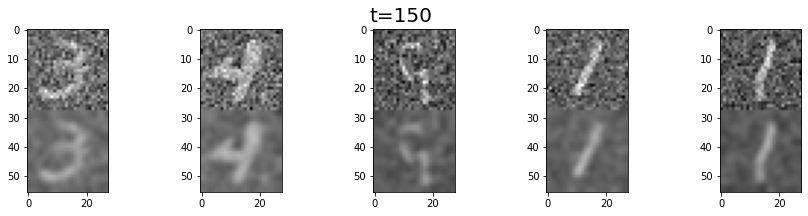

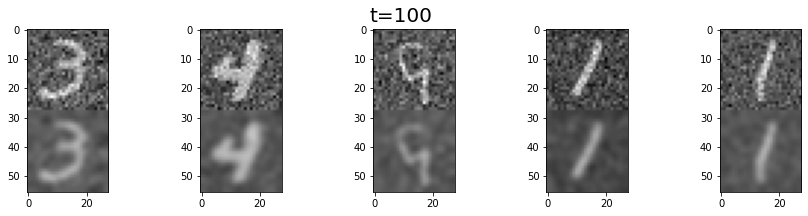

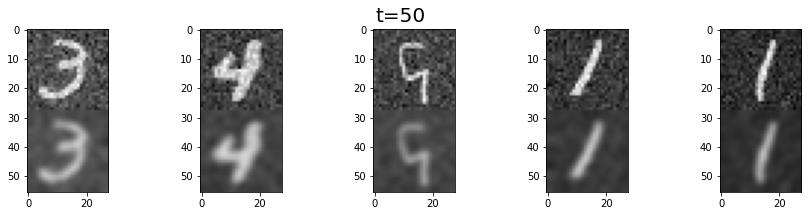

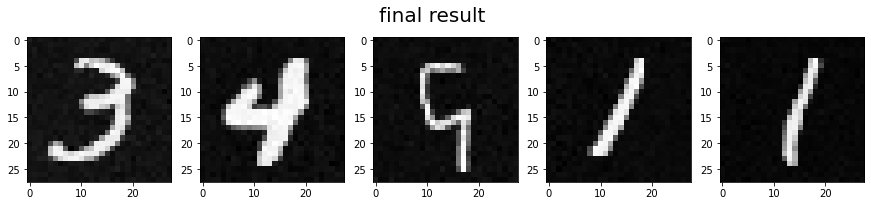

In [87]:
import itertools
do_blur = True
for subtensor, t in zip(predicted_x0s, timestep_store):
    if do_blur:
        plot_samples(torch.cat([subtensor, tF.gaussian_blur(subtensor, 5)], dim=2), f"t={t}")
    else:
        plot_samples(subtensor, f"t={t}")
#     flat_list = list(itertools.chain(*regular_list))
plot_samples(x_t, "final result")
